In [1]:
import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np
import copy
import time


In [2]:
class Model(nn.Module):
    def __init__(self,inp,out, activation, num_middle_units=120, num_layers=5):
        super(Model, self).__init__()
        self.input = nn.Linear(inp, num_middle_units, bias=True)
        torch.nn.Dropout(0.3)
        self.middle = nn.ModuleList()
        for i in range(num_layers):
            self.middle.append(nn.Linear(num_middle_units, num_middle_units, bias=True))
            torch.nn.Dropout(0.3)
        self.output = nn.Linear(num_middle_units, out, bias=True)
        self.activation = activation

    def forward(self, x):
        x = self.input(x)
        x = self.activation(x)
        for f in self.middle:
            x = f(x)
            x = self.activation(x)
        x = self.output(x)
        return x

    def predict(self, x):
        self.eval()
        y = self(x)
        x = x.cpu().numpy().flatten()
        y = y.cpu().detach().numpy().flatten()
        return [x, y]


In [3]:
def train(lam1, loader, EPOCH, BATCH_SIZE):
    state = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    

    lossTotal = np.zeros((EPOCH, 1))
    lossRegular = np.zeros((EPOCH, 1))
    lossDerivatives = np.zeros((EPOCH, 1))
    
    n = np.array(lam1).shape[0]
    m = EPOCH//n

    for epoch in range(EPOCH):
        epoch_mse_y = 0.0
        epoch_mse_dy = 0.0
        lamda = lam1[epoch%n]

        for step, (batch_x, batch_y) in enumerate(loader):  # for each training step
            
            b_x = Variable(batch_x)
            b_y = Variable(batch_y)


            model.eval()
            b_x.requires_grad = True

            output_y = model(b_x)
            output_y.sum().backward(retain_graph=True, create_graph=True)
            output_dy = b_x.grad
            b_x.requires_grad = False

            model.train()

            mse_y = loss_func(output_y, b_y[:,0:1])
            mse_dy = loss_func(output_dy, b_y[:,1:17])
            epoch_mse_y += mse_y.item() * BATCH_SIZE
            epoch_mse_dy += mse_dy.item() * BATCH_SIZE

            loss = mse_y + lamda * mse_dy


            optimizer.zero_grad()  
            loss.backward()  
            optimizer.step()  

        scheduler.step()
        epoch_mse_y /= num_data
        epoch_mse_dy /= num_data
        epoch_loss = epoch_mse_y+lamda*epoch_mse_dy

        y_pred = output_y
        
        lossTotal[epoch] = epoch_loss
        lossRegular[epoch] = epoch_mse_y
        lossDerivatives[epoch] = epoch_mse_dy
        if epoch%2==0:
            print('epoch', epoch,
              'mse_y', '{:.7f}'.format(epoch_mse_y),
              'mse_dy', '{:.7f}'.format(epoch_mse_dy),
              'loss', '{:.7f}'.format(epoch_loss))
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            state = copy.deepcopy(model.state_dict())
   
    return state, lossTotal, lossRegular, lossDerivatives

In [4]:
# Load both transonic and subsonic data
X_subTr = np.loadtxt('X_subTr.dat')
X_subV = np.loadtxt('X_subV.dat')
y_subCdTr = (np.loadtxt('y_subCdTr.dat')).reshape((-1,1))
y_subCdV = (np.loadtxt('y_subCdV.dat')).reshape((-1,1))
dy_subCdTr = np.loadtxt('dy_subCdTr.dat')
dy_subCdV = np.loadtxt('dy_subCdV.dat')
XTr = X_subTr
XV = X_subV
yTr = y_subCdTr
yV = y_subCdV
dyTr = dy_subCdTr
dyV = dy_subCdV
x_tr_ts=torch.from_numpy(XTr).float()
y_tr_ts=torch.from_numpy(yTr).float()
x_va_ts=torch.from_numpy(XV).float()
y_va_ts=torch.from_numpy(yV).float()
dy_tr_ts = torch.from_numpy(dyTr).float()         
dy_va_ts = torch.from_numpy(dyTr).float() 
print(np.shape(y_tr_ts))
print(np.shape(dy_tr_ts))
print(np.shape(torch.from_numpy(dyTr[:,0])))

train_y = torch.cat([y_tr_ts, dy_tr_ts], dim = 1).squeeze(1)
print(np.shape(train_y ))
train_y = torch.cat([y_tr_ts, dy_tr_ts], dim = 1)
print(np.shape(train_y ))

torch.Size([42039, 1])
torch.Size([42039, 16])
torch.Size([42039])
torch.Size([42039, 17])
torch.Size([42039, 17])


# ANN

In [5]:
train_y = torch.cat([y_tr_ts, dy_tr_ts], dim = 1)

tstart = time.time()
x, y = Variable(x_tr_ts), Variable(train_y)

model = Model(inp=16, out=1, activation=nn.ReLU(), num_middle_units=120, num_layers=5)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-6)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)
loss_func = torch.nn.MSELoss() 

torch.multiprocessing.set_sharing_strategy('file_system')

BATCH_SIZE = 500
EPOCH = 200
num_data = x_tr_ts.shape[1]
print(num_data)
torch_dataset = Data.TensorDataset(x, y)

loader = Data.DataLoader(
    dataset=torch_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, num_workers=2, )


lam1 = [0]
state, lossTotal_ANN, lossRegular_ANN, lossDerivatives_ANN = train(lam1, loader, EPOCH, BATCH_SIZE)
model.load_state_dict(state)

tfinal1 = time.time() - tstart
print (tfinal1)





16
epoch 0 mse_y 1.1883925 mse_dy 4.5035085 loss 1.1883925
epoch 2 mse_y 0.0507323 mse_dy 4.5041297 loss 0.0507323
epoch 4 mse_y 0.0351305 mse_dy 4.5002701 loss 0.0351305
epoch 6 mse_y 0.0311842 mse_dy 4.4978980 loss 0.0311842
epoch 8 mse_y 0.0293378 mse_dy 4.4949717 loss 0.0293378
epoch 10 mse_y 0.0279498 mse_dy 4.4913614 loss 0.0279498
epoch 12 mse_y 0.0266632 mse_dy 4.4875268 loss 0.0266632
epoch 14 mse_y 0.0254935 mse_dy 4.4832712 loss 0.0254935
epoch 16 mse_y 0.0244667 mse_dy 4.4798534 loss 0.0244667
epoch 18 mse_y 0.0235320 mse_dy 4.4768862 loss 0.0235320
epoch 20 mse_y 0.0225975 mse_dy 4.4741234 loss 0.0225975
epoch 22 mse_y 0.0216705 mse_dy 4.4713175 loss 0.0216705
epoch 24 mse_y 0.0208898 mse_dy 4.4685850 loss 0.0208898
epoch 26 mse_y 0.0201920 mse_dy 4.4658814 loss 0.0201920
epoch 28 mse_y 0.0195293 mse_dy 4.4632298 loss 0.0195293
epoch 30 mse_y 0.0188837 mse_dy 4.4604942 loss 0.0188837
epoch 32 mse_y 0.0183730 mse_dy 4.4576873 loss 0.0183730
epoch 34 mse_y 0.0179487 mse_dy 4

NameError: name 'plotLoss' is not defined

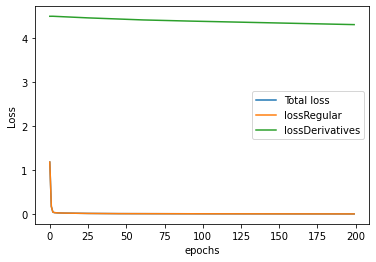

In [6]:
plt.plot(np.arange(len(lossTotal_ANN)),lossTotal_ANN,label='Total loss')
plt.plot(np.arange(len(lossRegular_ANN)),lossRegular_ANN,label='lossRegular')
plt.plot(np.arange(len(lossDerivatives_ANN)),lossDerivatives_ANN,label='lossDerivatives')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()

In [8]:
y_ANN = model(x_va_ts)

x_va_ts.requires_grad = True

y_ANN = model(x_va_ts)
y_ANN.sum().backward()
gradx_ANN = x_va_ts.grad
x_va_ts.requires_grad = False

e_test = np.linalg.norm(y_ANN.detach().numpy()- yV)/np.linalg.norm(yV)
print('e_test is:',e_test*100)

e_test_bar = np.linalg.norm(gradx_ANN.reshape(-1,1)- dyV.reshape(-1,1))/np.linalg.norm(dyV.reshape(-1,1))
print('e_test_bar is:',e_test_bar*100)

e_test is: 17.848982039535464
e_test_bar is: 97.79226380534762


# SANN

In [9]:
train_y = torch.cat([y_tr_ts, dy_tr_ts], dim = 1)

tstart = time.time()
x, y = Variable(x_tr_ts), Variable(train_y)

model = Model(inp=16, out=1, activation=nn.ReLU(), num_middle_units=120, num_layers=5)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-6)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)
loss_func = torch.nn.MSELoss()  


torch.multiprocessing.set_sharing_strategy('file_system')

BATCH_SIZE = 500
EPOCH = 200
num_data = x_tr_ts.shape[1]
print(num_data)
torch_dataset = Data.TensorDataset(x, y)

loader = Data.DataLoader(
    dataset=torch_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, num_workers=2, )

lam1 = [1]
state, lossTotal_SANN, lossRegular_SANN, lossDerivatives_SANN = train(lam1, loader, EPOCH, BATCH_SIZE)
model.load_state_dict(state)

tfinal1 = time.time() - tstart
print (tfinal1)




16
epoch 0 mse_y 28.5505474 mse_dy 4.4893080 loss 33.0398554
epoch 2 mse_y 12.6809290 mse_dy 4.4823394 loss 17.1632684
epoch 4 mse_y 3.6900899 mse_dy 4.4744851 loss 8.1645750
epoch 6 mse_y 0.5901693 mse_dy 4.4573171 loss 5.0474864
epoch 8 mse_y 0.2121792 mse_dy 4.4483418 loss 4.6605210
epoch 10 mse_y 0.0976355 mse_dy 4.4409231 loss 4.5385586
epoch 12 mse_y 0.0539934 mse_dy 4.4328238 loss 4.4868172
epoch 14 mse_y 0.0361745 mse_dy 4.4214141 loss 4.4575887
epoch 16 mse_y 0.0279041 mse_dy 4.4081129 loss 4.4360170
epoch 18 mse_y 0.0239248 mse_dy 4.3922463 loss 4.4161710
epoch 20 mse_y 0.0217729 mse_dy 4.3717607 loss 4.3935336
epoch 22 mse_y 0.0202202 mse_dy 4.3436492 loss 4.3638695
epoch 24 mse_y 0.0189887 mse_dy 4.3159948 loss 4.3349835
epoch 26 mse_y 0.0178591 mse_dy 4.2855366 loss 4.3033956
epoch 28 mse_y 0.0168086 mse_dy 4.2541410 loss 4.2709496
epoch 30 mse_y 0.0158991 mse_dy 4.2226842 loss 4.2385833
epoch 32 mse_y 0.0151310 mse_dy 4.1921458 loss 4.2072768
epoch 34 mse_y 0.0144848 mse_

NameError: name 'plotLoss' is not defined

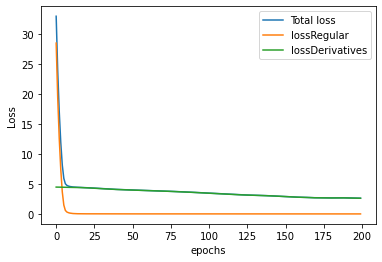

In [10]:
plt.plot(np.arange(len(lossTotal_SANN)),lossTotal_SANN,label='Total loss')
plt.plot(np.arange(len(lossRegular_SANN)),lossRegular_SANN,label='lossRegular')
plt.plot(np.arange(len(lossDerivatives_SANN)),lossDerivatives_SANN,label='lossDerivatives')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()

In [11]:
y_SANN = model(x_va_ts)

x_va_ts.requires_grad = True

y_SANN = model(x_va_ts)
y_SANN.sum().backward()
gradx_SANN = x_va_ts.grad
x_va_ts.requires_grad = False

e_test = np.linalg.norm(y_SANN.detach().numpy()- yV)/np.linalg.norm(yV)
print('e_test is:',e_test*100)

e_test_bar = np.linalg.norm(gradx_SANN.reshape(-1,1)- dyV.reshape(-1,1))/np.linalg.norm(dyV.reshape(-1,1))
print('e_test_bar is:',e_test_bar*100)

e_test is: 12.011328233393174
e_test_bar is: 78.47844945496963


# mSANN

In [12]:
train_y = torch.cat([y_tr_ts, dy_tr_ts], dim = 1)

tstart = time.time()
x, y = Variable(x_tr_ts), Variable(train_y)

model = Model(inp=16, out=1, activation=nn.ReLU(), num_middle_units=120, num_layers=5)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-6)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)
loss_func = torch.nn.MSELoss()  

torch.multiprocessing.set_sharing_strategy('file_system')

BATCH_SIZE = 500
EPOCH = 400
num_data = x_tr_ts.shape[1]
print(num_data)
torch_dataset = Data.TensorDataset(x, y)

loader = Data.DataLoader(
    dataset=torch_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, num_workers=2, )

lam1 = [.25, .5, .75, 1.0]
state, lossTotal_mSANN, lossRegular_mSANN, lossDerivatives_mSANN = train(lam1, loader, EPOCH, BATCH_SIZE)
model.load_state_dict(state)

tfinal1 = time.time() - tstart
print (tfinal1)





16
epoch 0 mse_y 1.9482688 mse_dy 4.4913745 loss 3.0711124
epoch 2 mse_y 0.1116342 mse_dy 4.4892382 loss 3.4785629
epoch 4 mse_y 0.0544189 mse_dy 4.4886204 loss 1.1765740
epoch 6 mse_y 0.0397216 mse_dy 4.4870877 loss 3.4050374
epoch 8 mse_y 0.0348877 mse_dy 4.4804665 loss 1.1550043
epoch 10 mse_y 0.0322944 mse_dy 4.4754732 loss 3.3888993
epoch 12 mse_y 0.0300919 mse_dy 4.4632328 loss 1.1459001
epoch 14 mse_y 0.0280535 mse_dy 4.4505184 loss 3.3659423
epoch 16 mse_y 0.0255095 mse_dy 4.4253326 loss 1.1318426
epoch 18 mse_y 0.0233740 mse_dy 4.4040490 loss 3.3264108
epoch 20 mse_y 0.0201960 mse_dy 4.3646966 loss 1.1113701
epoch 22 mse_y 0.0180976 mse_dy 4.3316158 loss 3.2668095
epoch 24 mse_y 0.0154520 mse_dy 4.2769659 loss 1.0846935
epoch 26 mse_y 0.0146784 mse_dy 4.2393552 loss 3.1941948
epoch 28 mse_y 0.0136122 mse_dy 4.1865433 loss 1.0602480
epoch 30 mse_y 0.0136718 mse_dy 4.1567815 loss 3.1312580
epoch 32 mse_y 0.0129882 mse_dy 4.1165484 loss 1.0421253
epoch 34 mse_y 0.0129856 mse_dy 4

epoch 286 mse_y 0.0020964 mse_dy 1.2636278 loss 0.9498173
epoch 288 mse_y 0.0023324 mse_dy 1.4961237 loss 0.3763633
epoch 290 mse_y 0.0019050 mse_dy 1.4523427 loss 1.0911620
epoch 292 mse_y 0.0047180 mse_dy 1.3529567 loss 0.3429572
epoch 294 mse_y 0.0021383 mse_dy 1.4835315 loss 1.1147869
epoch 296 mse_y 0.0025156 mse_dy 1.6545585 loss 0.4161552
epoch 298 mse_y 0.0016242 mse_dy 1.3879455 loss 1.0425834
epoch 300 mse_y 0.0010891 mse_dy 1.2047767 loss 0.3022833
epoch 302 mse_y 0.0011471 mse_dy 1.2284388 loss 0.9224762
epoch 304 mse_y 0.0010484 mse_dy 1.2179105 loss 0.3055260
epoch 306 mse_y 0.0035465 mse_dy 1.8584429 loss 1.3973787
epoch 308 mse_y 0.0031525 mse_dy 1.2383377 loss 0.3127369
epoch 310 mse_y 0.0011043 mse_dy 1.2169293 loss 0.9138013
epoch 312 mse_y 0.0020504 mse_dy 1.4539639 loss 0.3655414
epoch 314 mse_y 0.0016766 mse_dy 1.2808131 loss 0.9622864
epoch 316 mse_y 0.0013119 mse_dy 1.3714022 loss 0.3441624
epoch 318 mse_y 0.0017056 mse_dy 1.3700353 loss 1.0292321
epoch 320 mse_

NameError: name 'plotLoss' is not defined

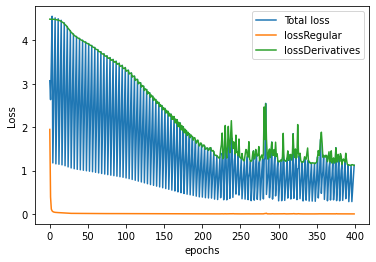

In [13]:
plt.plot(np.arange(len(lossTotal_mSANN)),lossTotal_mSANN,label='Total loss')
plt.plot(np.arange(len(lossRegular_mSANN)),lossRegular_mSANN,label='lossRegular')
plt.plot(np.arange(len(lossDerivatives_mSANN)),lossDerivatives_mSANN,label='lossDerivatives')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()

In [14]:
y_mSANN = model(x_va_ts)

x_va_ts.requires_grad = True

y_mSANN = model(x_va_ts)
y_mSANN.sum().backward()
gradx_mSANN = x_va_ts.grad
x_va_ts.requires_grad = False

e_test = np.linalg.norm(y_mSANN.detach().numpy()- yV)/np.linalg.norm(yV)
print('e_test is:',e_test*100)

e_test_bar = np.linalg.norm(gradx_mSANN.reshape(-1,1)- dyV.reshape(-1,1))/np.linalg.norm(dyV.reshape(-1,1))
print('e_test_bar is:',e_test_bar*100)



e_test is: 4.396825880886346
e_test_bar is: 85.0638531294488


In [17]:
 y_mSANN_n = []
lossRegular_mSANN_n = []
lossDerivatives_mSANN_n = []

for i in range(100):
    y_mSANN_n.append(y_mSANN[4*i].detach().numpy())
    lossRegular_mSANN_n = lossRegular_mSANN[4*i]
    lossDerivatives_mSANN_n = lossDerivatives_mSANN[4*i]
    
    

# plot prediction

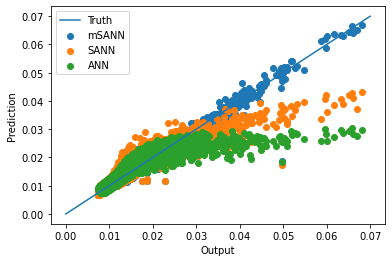

In [31]:
plt.scatter(yV,y_mSANN.detach().numpy(),label='mSANN')
plt.scatter(yV,y_SANN.detach().numpy(),label='SANN')
plt.scatter(yV,y_ANN.detach().numpy(),label='ANN')
plt.plot([0,0.07],[0,0.07],label = 'Truth')
plt.xlabel("Output")
plt.ylabel("Prediction")
plt.legend()

# plot yLoss

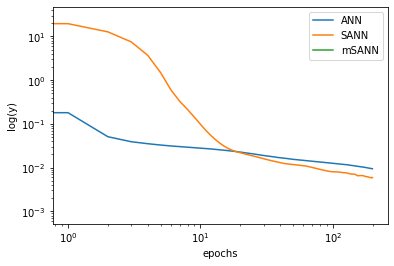

In [34]:
plt.loglog(range(len(lossRegular_ANN)),lossRegular_ANN,label='ANN')
plt.loglog(range(len(lossRegular_SANN)),lossRegular_SANN,label='SANN')
plt.loglog(range(len(lossRegular_mSANN_n)),lossRegular_mSANN_n,label='mSANN')
plt.xlabel("epochs")
plt.ylabel("log(y)")
plt.legend()

# plot dyLoss

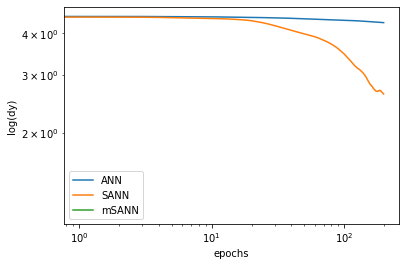

In [35]:
plt.loglog(range(len(lossDerivatives_ANN)),lossDerivatives_ANN,label='ANN')
plt.loglog(range(len(lossDerivatives_SANN)),lossDerivatives_SANN,label='SANN')
plt.loglog(range(len(lossDerivatives_mSANN_n)),lossDerivatives_mSANN_n,label='mSANN')
plt.xlabel("epochs")
plt.ylabel("log(dy)")
plt.legend()